In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')
data_x = df

# Use a compound data type for structured arrays
row_count = len(df)
data_y = np.zeros(row_count, dtype={'names':('Status', 'Survival_in_days'),
                          'formats':('?', 'f8')})
data_y['Status'] = df['status']
data_y['Survival_in_days'] = df['time']

In [3]:
data_y

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.), ( True,  577.), ( True,  184.),
       (False, 1840.), (False, 1842.), (False, 1821.), ( True, 1371.),
       ( True,  707.), (False, 1743.), (False, 1781.), ( True,  865.),
       ( True, 1684.), (False, 1701.), (False, 1701.), (False, 1693.),
       ( True,  379.), ( True, 1105.), ( True,  548.), ( True, 1296.),
       (False, 1483.), (False, 1570.), (False, 1469.), (False, 1472.),
       (False, 1342.), (False, 1349.), ( True, 1162.), (False, 1342.),
       ( True,  797.), (False, 1232.), (False, 1230.), (False, 1205.),
       (False, 1090.), (False, 1095.), ( True,  449.), (False,  972.),
       (False,  825.), (False, 2438.), (False, 2233.), ( True,  286.),
       (False, 1861.), ( True, 1080.), ( True, 1521.), (False, 1693.),
       ( True, 1528.), ( True,  169.), ( True,  272.), ( True,  731.),
      

In [4]:
import pandas as pd

pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,184.0
2,True,448.0
3,False,1342.0
4,False,1842.0
5,False,1693.0


Text(0.5, 0, 'time $t$')

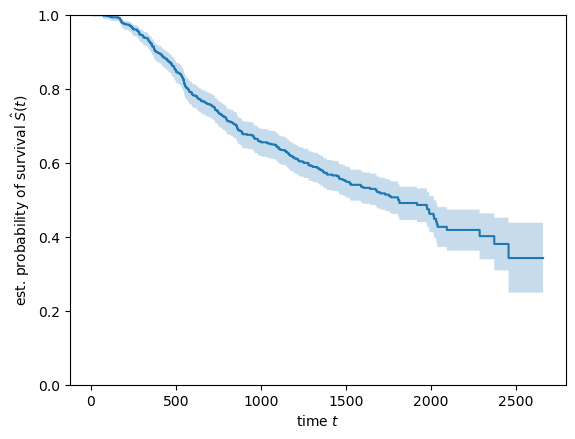

In [5]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Text(0.5, 0, 'time $t$')

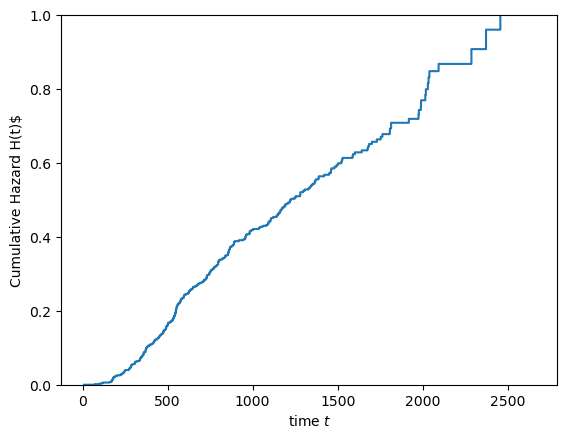

In [6]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import nelson_aalen_estimator

time, cum_hazard = nelson_aalen_estimator(
    data_y["Status"], data_y["Survival_in_days"])
plt.step(time, cum_hazard, where="post")
plt.ylim(0, 1)
plt.ylabel("Cumulative Hazard H(t)$")
plt.xlabel("time $t$")

In [7]:
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv

# Define the features (X) and the survival data (y)
features = ['treat', 'age', 'men', 'size', 'grade', 'nodes', 'prog', 'oest']
data_x = df[features]
data_y = Surv.from_arrays(event=df['status'] == 1, time=df['time'])

# Standardize the feature variables
scaler = StandardScaler()
data_x_scaled = scaler.fit_transform(data_x)

# Fit the Cox Proportional Hazards model
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_scaled, data_y)

CoxPHSurvivalAnalysis()

In [8]:
print(f'Concordance: {estimator.score(data_x_scaled, data_y)}')

Concordance: 0.6879809426475892


In [9]:
estimator = CoxPHSurvivalAnalysis().fit(data_x, data_y)

In [10]:
surv_funcs = estimator.predict_survival_function(data_x.iloc[:10])

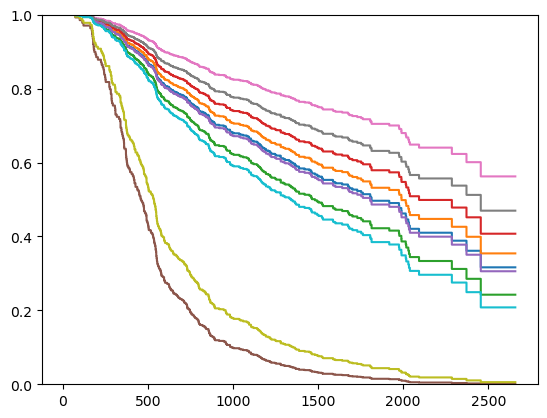

In [11]:
import matplotlib.pyplot as plt

for fn in surv_funcs:
    plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.show()

In [12]:
# Function to predict the expected survival time (mean survival)
def predict_expectation(model, X):
    # Predict survival function for each instance
    surv_fns = model.predict_survival_function(X)
    
    expected_times = []
    for surv_fn in surv_fns:
        times = surv_fn.x  # time points
        surv_probs = surv_fn.y  # survival probabilities
        
        # Calculate the expected time by integrating the survival function
        expected_time = np.trapezoid(surv_probs, times)
        expected_times.append(expected_time)
    
    return pd.Series(expected_times, index=X.index)

def predict_median(model, X):
    # Predict survival function for each instance
    surv_fns = model.predict_survival_function(X)
    
    median_times = []
    for surv_fn in surv_fns:
        times = surv_fn.x  # time points
        surv_probs = surv_fn.y  # survival probabilities
        
        # Find the time where the survival probability is closest to 0.5
        median_time = times[np.where(surv_probs <= 0.5)[0][0]] if any(surv_probs <= 0.5) else np.inf
        median_times.append(median_time)
    
    return pd.Series(median_times, index=X.index)

In [13]:
expected_survival_times = predict_expectation(estimator, data_x)

print(expected_survival_times)

0      1670.121889
1      1738.861490
2      1523.976162
3      1831.039168
4      1650.166592
          ...     
681    1392.695408
682     999.850452
683    1441.098512
684    1491.756252
685    1461.197480
Length: 686, dtype: float64


In [14]:
median_times = predict_median(estimator, data_x)

print(median_times)

0      1814.0
1      1990.0
2      1481.0
3      2093.0
4      1806.0
        ...  
681    1225.0
682     754.0
683    1329.0
684    1420.0
685    1363.0
Length: 686, dtype: float64
